In [1]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import path
import matplotlib.patches as patches
from skimage import draw
import scipy.ndimage as ndimage
import Utils
import georasters as gr
import cv2


/home/dlsaavedra/anaconda3/envs/new/lib/python3.7/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://migrating.pysal.org
  ), VisibleDeprecationWarning)


<Figure size 432x288 with 0 Axes>

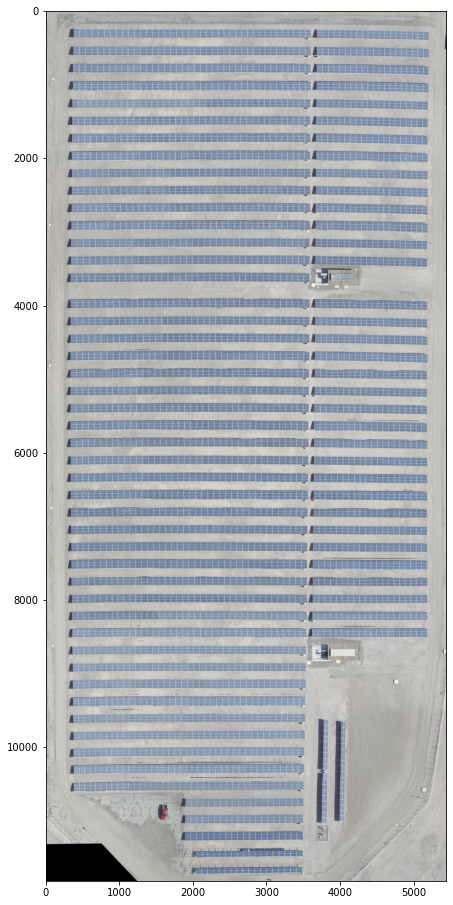

In [2]:
path_C = "El_Aguila/result_C.tif"

GR = gr.from_file(path_C)

plt.figure(0)
plt.figure(figsize=(16, 16))
plt.imshow((GR.raster[:3,:,:]).transpose((1, 2, 0))[::5,::5,:])

HSV = Utils.rgb2hsv((GR.raster[:3,:,:]).transpose((1, 2, 0)))


<Figure size 432x288 with 0 Axes>

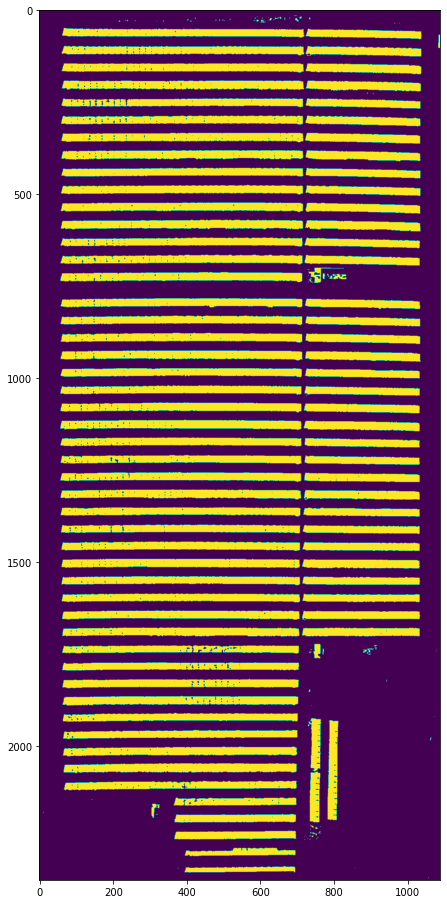

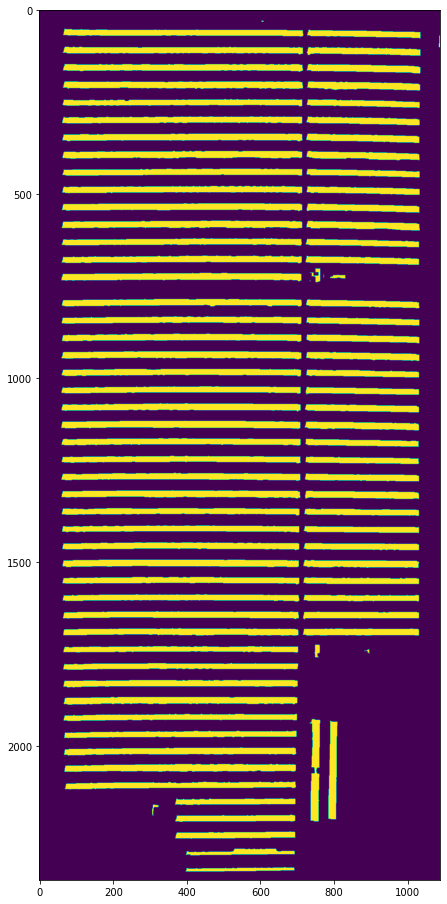

In [443]:

H = HSV[:, :, 0]
V = HSV[:, :, 2]

kernel_size = 31
edges = cv2.GaussianBlur((H).astype(np.uint8),(kernel_size, kernel_size),0)

H2 = np.ones(H.shape)
#H2 = cv2.GaussianBlur(H2,(9,9),0).astype('float32')
H2[edges > 270] = 0
#H2[H < 270] = 1
H2[edges < 210] = 0

kernel = np.ones((21, 21) , np.uint8)  # note this is a vertical kernel
closing_H2 = cv2.morphologyEx(H2.astype(float), cv2.MORPH_CLOSE, kernel)
erode_H2 = cv2.morphologyEx(closing_H2.astype(float), cv2.MORPH_ERODE, kernel)




plt.figure(0)
plt.figure(figsize=(16, 16))
plt.imshow(H2[::5,::5])

plt.figure(1)
plt.figure(figsize=(16, 16))
plt.imshow(erode_H2[::5,::5])

<Figure size 432x288 with 0 Axes>

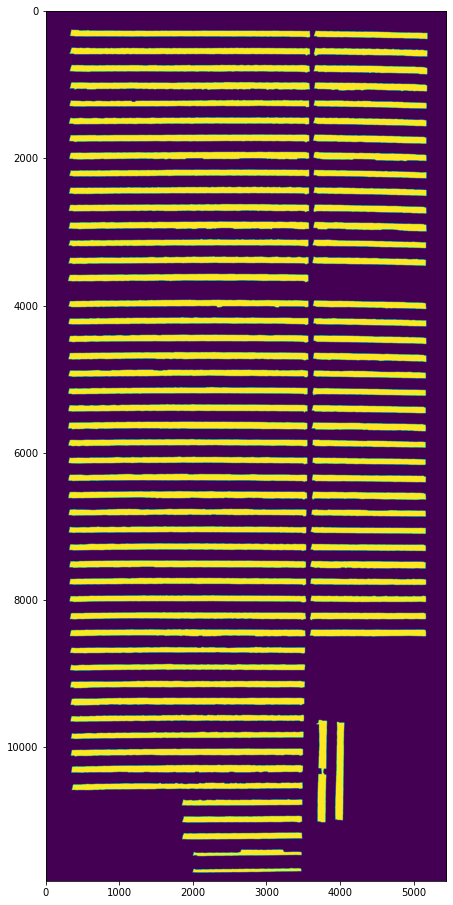

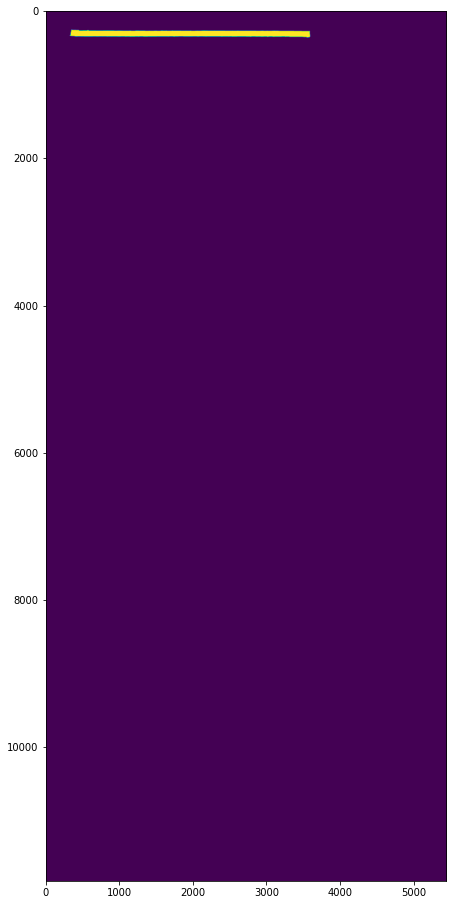

In [444]:

label_im, nb_labels = ndimage.label(erode_H2)#, structure= np.ones((2,2))) ## Label each connect region
label_areas = np.bincount(label_im.ravel())[1:]

min_area = 20000
L = np.zeros(label_im.shape)

for i in range(nb_labels):
    if label_areas[i] > min_area:
        L[label_im == (i + 1) ] = 1
        
        
label_im, nb_labels = ndimage.label(L)#, structure= np.ones((2,2))) ## Label each connect region
label_areas = np.bincount(label_im.ravel())[1:]


plt.figure(0)
plt.figure(figsize=(16, 16))
plt.imshow(L)

plt.figure(1)
plt.figure(figsize=(16, 16))
plt.imshow(label_im==1)
        

<Figure size 432x288 with 0 Axes>

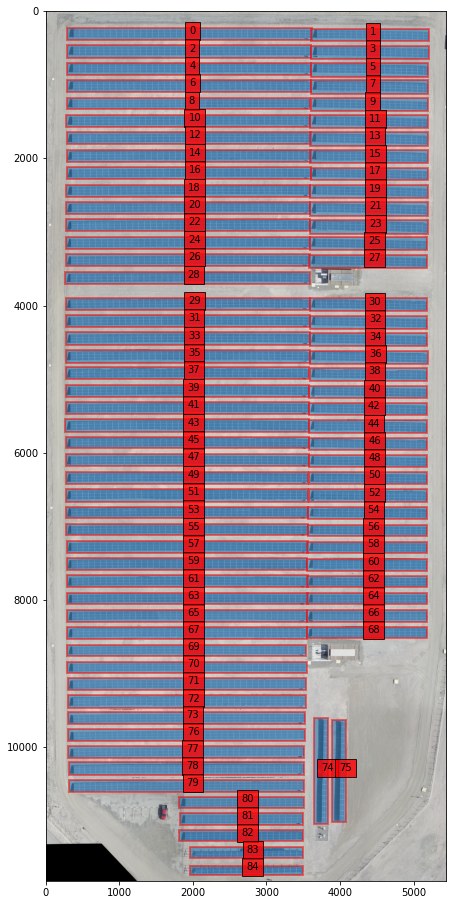

In [445]:
L_P = [] # (top-left, top-right, bottom-right, bottom-left) (x,y)
epsilon = 30


for i in range(1, nb_labels + 1):
    
    countours, hierarchy = cv2.findContours(np.uint8(label_im == i), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    x_max = np.max(countours[0][:, 0, 0]) + epsilon
    y_max = np.max(countours[0][:, 0, 1]) + epsilon
    x_min = np.min(countours[0][:, 0, 0]) - epsilon
    y_min = np.min(countours[0][:, 0, 1]) - epsilon
    
    List_P = [(x_min, y_min), (x_max, y_min), (x_max, y_max), (x_min, y_max)]
    L_P.append(List_P.copy())
    
L_P = np.stack(L_P, axis=0)



plt.figure(0)
plt.figure(figsize=(16, 16))
plt.imshow((GR.raster[:3,:,:]).transpose((1, 2, 0)))

ax = plt.gca()

for i,Poly in enumerate(L_P):
    poly = patches.Polygon(Poly,
                     linewidth=2,
                     edgecolor='red',
                     alpha=0.5,
                     fill = True)
    plt.text(np.mean([x[0]  for x in Poly]), np.mean([y[1]  for y in Poly]) , str(i),  bbox=dict(facecolor='red', alpha=0.8))

    ax.add_patch(poly)

<Figure size 432x288 with 0 Axes>

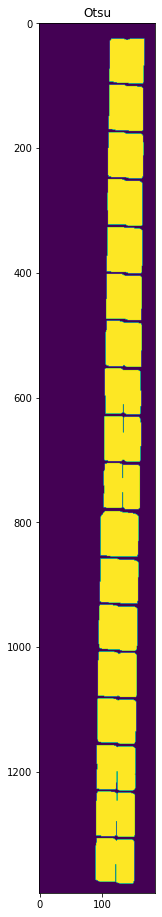

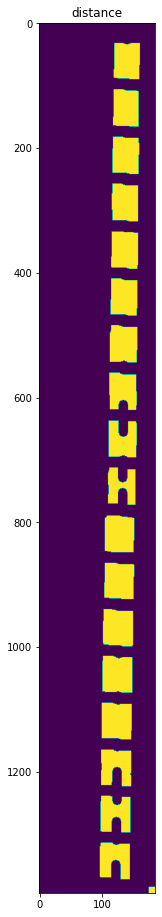

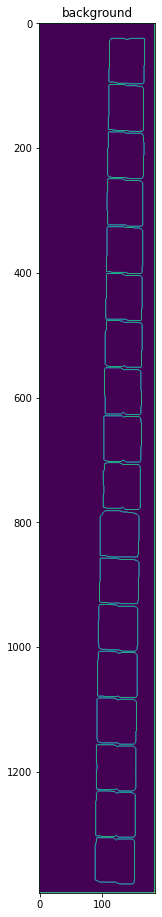

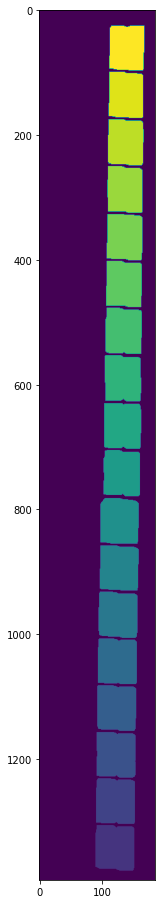

In [494]:
P = L_P[75] 
x_min = np.min(P[:,0])
x_max = np.max(P[:,0])
y_min = np.min(P[:,1]) 
y_max = np.max(P[:,1])
A = (GR.raster[:3,:,:]).transpose((1, 2, 0))[y_min : y_max, x_min : x_max,:]

HSV_A = Utils.rgb2hsv(A)
S = (HSV_A[:,:,1]* 255).astype(np.uint8)
V = (HSV_A[:,:,2]* 255).astype(np.uint8)
V[V>125] = 0
ret1, thresh1 = cv2.threshold(cv2.GaussianBlur(V, (11, 11),0), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
ret2, thresh2 = cv2.threshold(cv2.GaussianBlur(S, (11, 11),0), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

thresh = thresh1 * thresh2
thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN,  np.ones((11,11), dtype=np.uint8), iterations = 2)
# Perform the distance transform algorithm
dist = cv2.distanceTransform(thresh, cv2.DIST_L2, 3)
# Normalize the distance image for range = {0.0, 1.0}
# so we can visualize and threshold it
cv2.normalize(dist, dist, 0, 1.0, cv2.NORM_MINMAX)
# Threshold to obtain the peaks
# This will be the markers for the foreground objects
_, dist = cv2.threshold((dist*255).astype(np.uint8), 0, 255 , cv2.THRESH_BINARY + cv2.THRESH_OTSU)
# Dilate a bit the dist image
kernel1 = np.ones((3,3), dtype=np.uint8)
dist = cv2.dilate(dist, kernel1 , iterations = 1)
dist = cv2.erode(dist, kernel1 , iterations = 1)

dist[S < np.min(S) + np.ptp(S)/6] = 0


#dist[0: 10,-10:] = 255
dist[-10:,-10:] = 255

dist_8u = dist.astype('uint8')

plt.figure(0)
plt.figure(figsize=(16, 16))
plt.title("Otsu")
plt.imshow(thresh)                                

plt.figure(1)
plt.figure(figsize=(16, 16))
plt.title("distance")
plt.imshow(dist_8u)
    
# Create the CV_8U version of the distance image
# It is needed for findContours()

# Find total markers
contours, _ = cv2.findContours(dist_8u, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# Create the marker image for the watershed algorithm
markers = np.zeros(dist.shape, dtype=np.int32)
# Draw the foreground markers
for i in range(len(contours)):
    cv2.drawContours(markers, contours, i, (i+1), -1)


markers = cv2.watershed(cv2.cvtColor(thresh,cv2.COLOR_GRAY2RGB), markers)
#markers = cv2.watershed(A, markers)

plt.figure(2)
plt.figure(figsize=(16, 16))
plt.title("background")
plt.imshow(markers==-1)

Areas = []
for i in range(np.max(markers)):
    Areas.append(np.sum(markers == i))

m = np.mean(Areas)
h = np.std(Areas) * 1.6 / np.sqrt(np.size(Areas))

L = (Areas > m - h) * (Areas < m + h)

for i in range(np.max(markers)):
    if not(L[i]):
        markers[markers == i] = -1

plt.figure(3)
plt.figure(figsize=(16, 16))
plt.imshow(markers)

<Figure size 432x288 with 0 Axes>

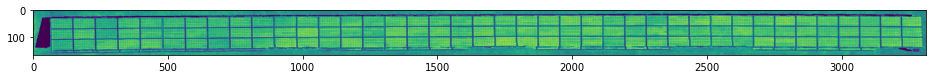

In [491]:
plt.figure(3)
plt.figure(figsize=(16, 16))
plt.imshow(V)